# Importing RDKit and other necessary packages

In [2]:
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import rdmolfiles
    from rdkit.Chem import Descriptors, Crippen, QED
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG=True
except ImportError:
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
    exit()

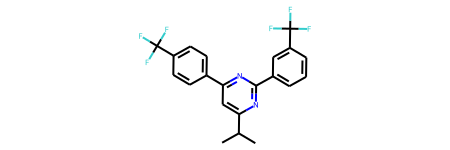

In [3]:
mol = Chem.MolFromSmiles(' C ( C ) ( C ) c 1 c c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c ( - c 2 c c c c ( C ( F ) ( F ) F ) c 2 ) n 1'.replace(' ', ''))
mol

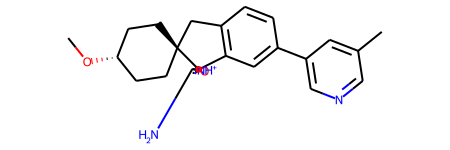

In [4]:
mol = Chem.MolFromSmiles('CO[C@@H]1CC[C@@]2(CC1)Cc1c([C@]32COC(=[NH+]3)N)cc(cc1)c1cncc(c1)C')
mol

In [5]:
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs

In [6]:
from molvs import standardize_smiles

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Defining functions for computing physicochemical properties

In [8]:
def lipsinki_properties(samples_df):
    hd = []
    ha = []
    rb = []
    tpsa = []
    for s in samples_df['smiles']:
        try:
            m = Chem.MolFromSmiles(s)
            hd_s = Chem.Lipinski.NumHDonors(m)
            ha_s = Chem.Lipinski.NumHAcceptors(m)
            rb_s = Chem.Lipinski.NumRotatableBonds(m)
            tpsa_s = Chem.Descriptors.TPSA(m)
            hd.append(hd_s)
            ha.append(ha_s)
            rb.append(rb_s)
            tpsa.append(tpsa_s)
        except:
            print(s)
            continue
    return hd, ha, rb, tpsa


def molecular_properties(samples_df):
    mw = []
    logp = []
    qed = []
    for s in samples_df['smiles']:
        try:
            m = Chem.MolFromSmiles(s)
            mw_s = Descriptors.ExactMolWt(m)
            logp_s = Crippen.MolLogP(m, includeHs=True)
            qed_s = QED.qed(m)
            mw.append(mw_s)
            logp.append(logp_s)
            qed.append(qed_s)
        except:
            print(s)
            continue
    return mw, logp, qed


"""Computing Synthetic Accessibility Score (SAS)"""
#
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    data = pickle.load(gzip.open('/home/iit/CDGCN/outputs/fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    #print('smiles\tName\tsa_score')
    s = []
    for i, m in enumerate(mols):
        if m is None:
            continue

        s.append(calculateScore(m))

        #smiles = Chem.MolToSmiles(m)
    return s
        #print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)

#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#

In [ ]:
# SMILES baseline output
data_path = '/home/iit/CDGCN/outputs/Grechishnikova/Dataset2/generated_samples'
for beam_size in [10, 100]:
    os.system(f'mkdir {data_path}/{beam_size}')
    for run in range(1, 11):
        os.system(f'mkdir {data_path}/{beam_size}/run{run}')
        with open(f'{data_path}/run{run}/protein.seq.decode.results_ds2_ep6000_beam{beam_size}') as f:
            for prot_id, line in enumerate(f):
                smiles = []
                for ele in line.strip().split('\t'):
                    try:
                        smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(ele.replace(' ', ''))))
                    except:
                        continue
                pd.DataFrame(smiles, columns=['smiles'],).to_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id+1}_generated_samples.csv', index=False)

# Computing chemical validity and feasibility and physicochemical properties

In [25]:
modelname = 'CDGCN'

In [ ]:
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

for beam_size in [10, 100, 1000]:
    for run in range(1, 11):
        for prot_id in range(1, 11):
            smiles_df = pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv')
            smiles_df['MW'], smiles_df['logP'], smiles_df['QED'] = molecular_properties(smiles_df)
            smiles_df['HD'], smiles_df['HA'], smiles_df['RB'], smiles_df['TPSA'] = lipsinki_properties(smiles_df)
            suppl = [Chem.MolFromSmiles(smiles) for smiles in smiles_df['smiles']]
            smiles_df['SAS'] = processMols(suppl)
            smiles_df.to_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv', index=False)
            print(f'Protein {prot_id} of run {run} of beam size {beam_size} stored.')

In [26]:
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100, 1000]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
all_smiles_df_beams[0][0][0]

,smiles,MW,logP,QED,HD,HA,RB,TPSA,SAS
0,O=CNC(Cc1cnn(-c2cccc(NC(=O)c3cc(C(F)(F)F)c(F)c...,504.142068,3.90160,0.302273,3,5,9,113.32,3.277372
1,CS(=O)(=O)N(c1cccc(C(=O)O)c1)c1cccc(C(F)(F)F)c1,359.043914,3.50130,0.906635,1,3,4,74.68,2.308986
2,CCCC1CC(c2ccc(-c3ccccc3CN(C)C(N)=O)cc2)NC1=O,365.210327,3.84140,0.815920,2,2,6,75.43,3.245543
3,CCCNC(=O)c1cc(-c2ccc(CN3CC=C4CCCC(F)(F)C4(C)C3...,468.233683,4.56470,0.608415,2,4,6,88.32,3.615708
4,CC(C)Oc1ccc(CNCC2COc3ccccc3C(=O)N2)cc1Cl,374.139720,3.40780,0.813092,2,4,6,59.59,2.871279
5,O=C1Nc2cc(-c3ccc4c(CN5CCCC5)n[nH]c4c3)ccc2C1C1...,416.221226,4.28800,0.665751,2,4,4,70.25,3.305602
6,CCC(C)C(NC(=O)NC1=CS(=O)(=O)N2CCCC2C1)c1ccc(C(...,498.160677,1.80170,0.523359,3,6,7,141.75,4.151892
7,Cc1ccc(NC(=O)C2CN3CCC2CC3)cc1-c1cccc(C=CCO)c1,376.215078,3.94782,0.830820,2,3,5,52.57,3.647041
8,CC=C1COCC2C1N(Cc1ccccc1)CCN(S(=O)(=O)c1ccccc1-...,547.214092,3.69540,0.277514,2,6,6,99.18,3.889670


In [27]:
import statistics

nprot = 10
print(f'{modelname}\n----------------------------------------')

for j, beam_size in enumerate([10, 100, 1000]):
    print(f'Beam Size {beam_size}')
    valid_ligs_ = []
    unique_ligs_ = []
    logP_ = []
    mw_ = []
    hd_ = []
    ha_ = []
    rb_ = []
    qed_ = []
    qedstdev_ = []
    sas_ = []
    tpsa_ = []
    for run in range(10):
        unique_ligsi_ = []
        valid_ligsi_ = []
        logPi_ = []
        mwi_ = []
        hdi_ = []
        hai_ = []
        rbi_ = []
        qedi_ = []
        sasi_ = []
        tpsai_ = []
        for i in range(nprot):
            #print('Protein {}'.format(i+1))
            ns = len(all_smiles_df_beams[j][run][i])
            valid_ligsi_.append(100*ns/beam_size)
            ns_u = all_smiles_df_beams[j][run][i]['smiles'].nunique()
            if ns != 0:
                unique_ligsi_.append(100*ns_u/beam_size)
            else:
                unique_ligsi_.append(0)
            ns = beam_size
            if ns != 0:
                logPi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['logP'] < 5])/ns)
                mwi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['MW'] < 500])/ns)
                hdi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['HD'] < 5])/ns)
                hai_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['HA'] < 10])/ns)
                rbi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['RB'] < 10])/ns)
                qedi_.append(all_smiles_df_beams[j][run][i]['QED'].sum()/ns)
                sasi_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['SAS'] < 6])/ns)
                tpsai_.append(100*(all_smiles_df_beams[j][run][i]['smiles'].nunique()/ns)*len(all_smiles_df_beams[j][run][i].loc[all_smiles_df_beams[j][run][i]['TPSA'] < 140])/ns)
            else:
                logPi_.append(0)
                mwi_.append(0)
                hdi_.append(0)
                hai_.append(0)
                rbi_.append(0)
                qedi_.append(0)
                sasi_.append(0)
                tpsai_.append(0)
        valid_ligs_.append(sum(valid_ligsi_)/nprot)
        unique_ligs_.append(sum(unique_ligsi_)/nprot)
        logP_.append(sum(logPi_)/nprot)
        mw_.append(sum(mwi_)/nprot)
        hd_.append(sum(hdi_)/nprot)
        ha_.append(sum(hai_)/nprot)
        rb_.append(sum(rbi_)/nprot)
        tpsa_.append(sum(tpsai_)/nprot)
        qed_.append(sum(qedi_)/nprot)
        #qed_.append(statistics.pstdev(qedi_))
        sas_.append(sum(sasi_)/nprot)
    print('Validity:', round(sum(valid_ligs_)/10, 1),'+-',round(statistics.pstdev(valid_ligs_), 2))
    print('Uniqueness:', round(sum(unique_ligs_)/10, 1),'+-',round(statistics.pstdev(unique_ligs_), 2))
    print('LogP:', round(sum(logP_)/10, 1),'+-',round(statistics.pstdev(logP_), 2))
    print('MW:', round(sum(mw_)/10, 1),'+-',round(statistics.pstdev(mw_), 2))
    print('HD', round(sum(hd_)/10, 1),'+-',round(statistics.pstdev(hd_), 2))
    print('HA', round(sum(ha_)/10, 1),'+-',round(statistics.pstdev(ha_), 2))
    print('RB', round(sum(rb_)/10, 1),'+-',round(statistics.pstdev(rb_), 2))
    print('TPSA', round(sum(tpsa_)/10, 1),'+-',round(statistics.pstdev(tpsa_), 2))
    print('QED', round(sum(qed_)/10, 2),'+-',round(statistics.pstdev(qed_), 2))
    print('SAS', round(sum(sas_)/10, 1),'+-',round(statistics.pstdev(sas_), 2))
    print()

DGGNP
----------------------------------------
Beam Size 10
Validity: 94.5 +- 1.63
Uniqueness: 94.5 +- 1.63
LogP: 77.4 +- 4.22
MW: 71.9 +- 4.35
HD 85.0 +- 4.05
HA 89.5 +- 2.69
RB 78.2 +- 2.89
TPSA 83.5 +- 3.48
QED 0.54 +- 0.02
SAS 89.5 +- 2.96

Beam Size 100
Validity: 94.1 +- 0.86
Uniqueness: 94.1 +- 0.86
LogP: 76.9 +- 2.94
MW: 70.9 +- 2.07
HD 84.0 +- 1.6
HA 88.1 +- 1.66
RB 74.7 +- 1.74
TPSA 82.0 +- 2.0
QED 0.54 +- 0.02
SAS 88.2 +- 1.67

Beam Size 1000
Validity: 94.0 +- 0.51
Uniqueness: 93.9 +- 0.51
LogP: 77.0 +- 2.6
MW: 71.0 +- 2.1
HD 84.1 +- 1.56
HA 87.8 +- 1.02
RB 74.8 +- 1.76
TPSA 82.0 +- 1.76
QED 0.54 +- 0.02
SAS 87.8 +- 0.96



# Computing generation times

In [9]:
import statistics
modelname = 'CDGCN'
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

pred_times = []
for run in range(1, 11):
    with open(f'{data_path}/10/run{run}/samples_evaluation.txt') as f:
        for line in f:
            continue
        pred_times.append(int(line[12:-3]))
print(round(statistics.mean(pred_times)/1000, 1), '+-', round(statistics.stdev(pred_times)/1000, 2))

17.8 +- 1.62


In [12]:
modelname = 'Grechishnikova'
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

pred_times = []
for run in range(1, 11):
    with open(f'{data_path}/run{run}/samples_evaluation.txt') as f:
        for line in f:
            if int(line[15:18]) == 10:
                pred_times.append(int(line[27:-3]))
print(round(statistics.mean(pred_times)/1000, 1), '+-', round(statistics.stdev(pred_times)/1000, 2))

42.1 +- 2.1


# Rate of correctly generated outputs for known proteins
Using classifier, predict rate of correctly generated outputs.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

import joblib
import numpy as np
import pandas as pd

## Getting ECFP6 fingerprints from molecules

In [8]:
# Code credit: https://drzinph.com/ecfp6-fingerprints-in-python-part-3/

class ECFP6:
    def __init__(self, smiles):
        self.mols = [Chem.MolFromSmiles(i) for i in smiles]
        self.smiles = smiles

    def mol2fp(self, mol, radius = 3):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = radius)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        return array

    def compute_ECFP6(self, name):
        bit_headers = ['bit' + str(i) for i in range(2048)]
        arr = np.empty((0,2048), int).astype(int)
        for i in self.mols:
            fp = self.mol2fp(i)
            arr = np.vstack((arr, fp))
        df_ecfp6 = pd.DataFrame(np.asarray(arr).astype(int),columns=bit_headers)
        df_ecfp6.insert(loc=0, column='smiles', value=self.smiles)
        df_ecfp6.to_csv(name+'_ECFP6.csv', index=False)

In [24]:
for i, beam_size in enumerate([10, 100, 1000]):
    for run, smiles_df_list in enumerate(all_smiles_df_beams[i]):
        for prot_id, smiles_df in enumerate(smiles_df_list):
            smiles = []
            for s in smiles_df['smiles']:
                try:
                    smiles.append(standardize_smiles(s))
                except:
                    continue

            ## Compute ECFP6 Fingerprints and export a csv file.
            ecfp6_descriptor = ECFP6(smiles)        # create your ECFP6 object and provide smiles
            ecfp6_descriptor.compute_ECFP6(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples')

RDKit ERROR: [05:33:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8
[05:33:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8

RDKit ERROR: 
RDKit ERROR: [05:59:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4 6 7 8 9
[05:59:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4 6 7 8 9

RDKit ERROR: 
RDKit ERROR: [06:19:21] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5 7 8 9 10 13
[06:19:21] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5 7 8 9 10 13

RDKit ERROR: 
RDKit ERROR: [06:20:08] Can't kekulize mol.  Unkekulized atoms: 0 3 4 6 7 8 12 13 18
[06:20:08] Can't kekulize mol.  Unkekulized atoms: 0 3 4 6 7 8 12 13 18

RDKit ERROR: 
RDKit ERROR: [06:29:52] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5 8 9 10 14 15
[06:29:52] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5 8 9 10 14 15

RDKit ERROR: 
RDKit ERROR: [06:32:12] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7
[06:32:12] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7

RDKit ERROR: 


In [65]:
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100, 1000]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples_ECFP6.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
all_smiles_df_beams[0][0][0]

In [66]:
all_smiles_df_beams[0][0][0]

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit2038,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047
0,COc1cc2ccnnc2cc1OCCCN(C(=O)Cc1csc(C(C)(C)O)n1)...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,COc1cc(C(=O)Nc2cccc(-c3[nH]c(=O)cc(Cl)c3Cl)c2)...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,COc1ccc(NC(=O)Nc2ccc(C)c(Cl)c2)cc1OC(C)C,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,COc1cc(-c2cn[nH]c2)ccc1C(=O)NCCCC1CC(C(OCCN)c2...,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,COc1cc2ncnc(Nc3ccc(Cl)cc3NC3CCNCC3)c2cc1OC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NC(=O)CC(c1ccccc1)c1ncn2cc(Br)c(Cl)nc12,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,COc1ccccc1-c1nc(Oc2cccc(C(=O)Nc3cc(Oc4ccc(Cl)c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,COc1cc2c(Nc3c(Cl)cccc3Cl)ncnc2cc1OCCCNC1CC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import statistics
prot_id = 2
for i, beam_size in enumerate([10, 100, 1000]):
    print(f'Beam {beam_size}:')
    score = []
    for run, smiles_df_list in enumerate(all_smiles_df_beams[i]):
        score_i = []
        for prot_id, smiles_df in enumerate(smiles_df_list):
            joblib_file = f'/home/iit/CDGCN/outputs/classifiers/p{prot_id+1}_RF.pkl')
            classifier = joblib.load(joblib_file)
            # Calculate the accuracy and predictions
            X_test = smiles_df.drop(columns='smiles')
            score_i.append(100*classifier.score(X_test, np.repeat([[1, 0]],len(X_test), axis=0)))
        score.append(score_i)
    score_ = [s[prot_id-1] for s in score]
    #print(score_)
    print(round(statistics.mean(score_), 1),'+-',round(statistics.pstdev(score_), 2))
    print()

# Computing Tanimoto similarity
Similarity between generated molecules and molecules in the dataset.

In [8]:
nprot = 1000
# Get known ligands
known_drugs = []
for i in range(nprot):
    known_drugs.append(pd.read_csv(f'/home/iit/CDGCN/data/bindingdb/train_dataset/train_4_org_1000_112/Protein{i+1}_known_ligands.csv'))

In [20]:
# CDGCN
data_path = f'/home/iit/CDGCN/outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100, 1000]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples_ECFP6.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
gen_drugs = all_smiles_df_beams[0][0]

# Grechishnikova
data_path = f'/home/iit/Grechishnikova/outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples_ECFP6.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
gen_drugs = all_smiles_df_beams[0][0]

# Li et al.
data_path = f'/home/iit/Li et al./outputs/{modelname}/Dataset2/generated_samples'

all_smiles_df_beams = []
for beam_size in [10, 100, 1000]:
    smiles_df_beams = []
    for run in range(1, 11):
        smiles_df = []
        for prot_id in range(1, 11):
            smiles_df.append(pd.read_csv(f'{data_path}/{beam_size}/run{run}/Protein{prot_id}_generated_samples_ECFP6.csv'))
        smiles_df_beams.append(smiles_df)
    all_smiles_df_beams.append(smiles_df_beams)
gen_drugs = all_smiles_df_beams[0][0]

In [21]:
similarity_efcp4 = []
similarity_efcp41 = []
similarity_efcp42 = []
for prot_id in range(1000):
    bulk_ECFP4_fps_known = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in known_drugs[prot_id]['smiles'].unique()]
    
    bulk_ECFP4_fps_gen = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in gen_drugs[prot_id]['smiles'].unique()]
    similarity_efcp4 += [DataStructs.FingerprintSimilarity(y, x) for y in bulk_ECFP4_fps_gen for x in bulk_ECFP4_fps_known]
    
    bulk_ECFP4_fps_gen = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in gen_drugs1[prot_id]['smiles'].unique()]
    similarity_efcp41 += [DataStructs.FingerprintSimilarity(y, x) for y in bulk_ECFP4_fps_gen for x in bulk_ECFP4_fps_known]
    
    bulk_ECFP4_fps_gen = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2) for x in gen_drugs2[prot_id]['smiles'].unique()]
    similarity_efcp42 += [DataStructs.FingerprintSimilarity(y, x) for y in bulk_ECFP4_fps_gen for x in bulk_ECFP4_fps_known]

In [22]:
import statistics
print(round(statistics.mean(similarity_efcp4), 2), '+-', round(statistics.pstdev(similarity_efcp4), 2))
print(round(statistics.mean(similarity_efcp41), 2), '+-', round(statistics.pstdev(similarity_efcp41), 2))
print(round(statistics.mean(similarity_efcp42), 2), '+-', round(statistics.pstdev(similarity_efcp42), 2))

0.12 +- 0.04
0.13 +- 0.05
0.13 +- 0.04


# Plotting losses per epoch for CDGCN and Li et al.

In [32]:
import matplotlib.pyplot as plt

In [33]:
li_losses = []
with open('/home/iit/CDGCN/outputs/Li_et_al/Dataset2/model/log.out') as f:
    for i, line in enumerate(f):
        if i > 1 and len(line.split('\t')) == 4:
            li_losses.append(float(line.split('\t')[2]))
#li_losses

In [34]:
cdgcn_losses = []
with open('/home/iit/CDGCN/outputs/CDGCN/Dataset2/model/log.out') as f:
    for i, line in enumerate(f):
        if i > 1 and len(line.split('\t')) == 4 and line.split('\t')[0] != 'step':
            cdgcn_losses.append(float(line.split('\t')[2]))
#cdgcn_losses

In [38]:
print('Mean losses:')
print(f'Li et al.: {sum(li_losses)/len(li_losses)}')
print(f'CDGCN: {sum(cdgcn_losses)/len(cdgcn_losses)}')

Mean losses:
Li et al.: 21.380749388209114
DGGNP: 20.192524721984586


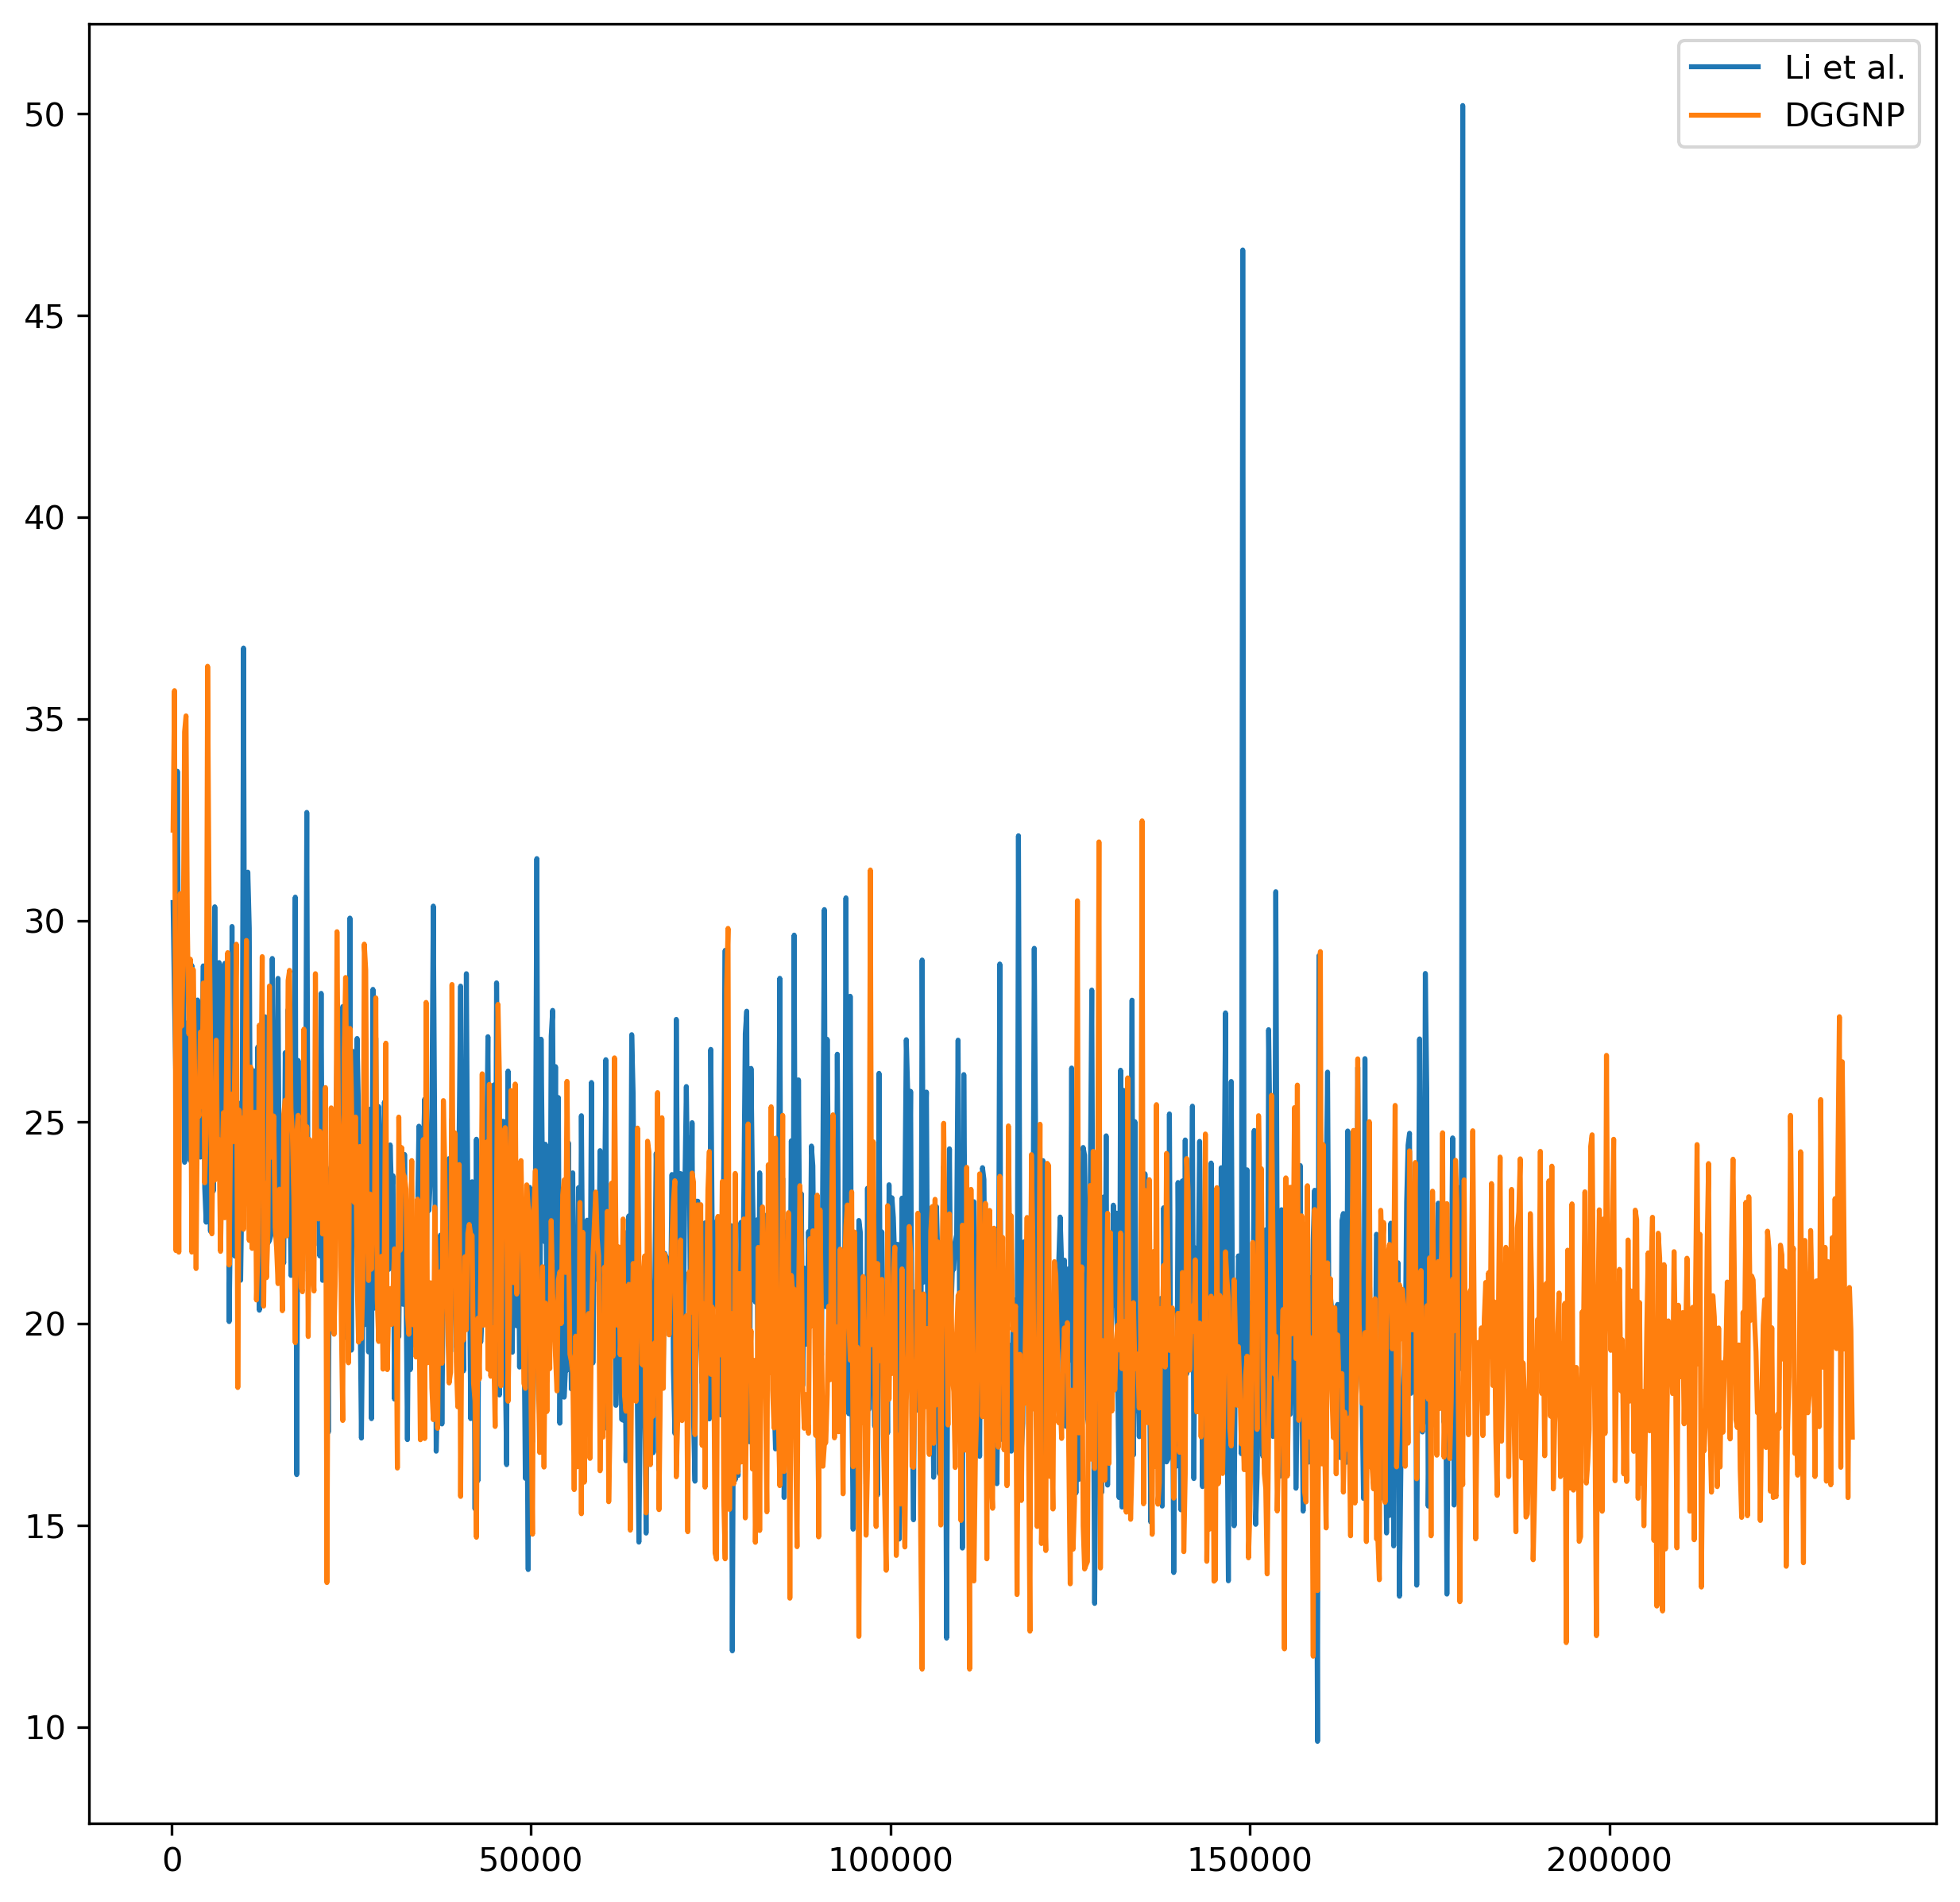

In [39]:
plt.figure(figsize=(10,10), dpi=300)

li_x = [x*200 for x in range(1, len(li_losses)+1)]
cdgcn_x = [x*200 for x in range(1, len(cdgcn_losses)+1)]

plt.plot(li_x, li_losses)
plt.plot(cdgcn_x, cdgcn_losses)

plt.legend(['Li et al.', 'CDGCN'])

plt.show()